# Bike Sharing Rebalancing Problem

The following implementation is derivated from the following paper: https://www.sciencedirect.com/science/article/abs/pii/S0305048313001187


## Introduction

Il Bike sharing negli ultimi anni sta riscutendo un notevole successo per via dei suoi numerosi vantaggi che vanno dalla riduzione del traffico ad una maggiore sostenibilità. Con il crescente interesse verso l'adozione di questo modello sono aumentate anche le ricerche per ottimizzare il sistema e ridurre i suoi costi.

In generale in un sistema di bike sharing le stazioni sono composte da differenti slot, ognuno dei quali può ospitare una singola bicicletta. Nei sistemi moderni le stazioni sono connesse ad internet in maniera che il sistema possa essere monitorato e le informazioni raccolte possano essere usate per migliorare il sistema.

Tra i costi giornalieri del sistema che includono manutenzione, assicurazione, elettricità il costo che il paper va ad analizzare è il <b>costo di redistribuzione</b>.

Infatti a fine giornata infatti ci possono essere stazioni completamente vuote o stazioni piene quello che si fa solitamente è nella notte redistribuire le bici nelle varie stazioni.
Il riposizionamento è fatto in base alle <b>capacità</b> dei <b>veicoli</b> presenti in un deposito centrale che prende le biciclette da stazioni dove il livello di <b>occupazione</b> è troppo alto e le rialloca nelle stazioni dove il livello è troppo basso. <b>Solitamente una quantità di biciclette è tenuto nel deposito consetendo una più flessibile riallocazione</b>. Il problema è noto in letteratura come Bike sharing Rebalacing Problem (BRP).
Nel paper sono proposte 4 <b>Mixed Integer Linear Programming(MILP)</b> formulation. Questa tesina tratta la <b>formulazione F4.</b>

Il problema è una versione più specifica del problema del commesso viaggiatore, le variabili del problema sono:

| Variable Name  | Description |
| ------------- | ------------- |
| <i>V</i>   | Set of vertices |
| <i>A</i>   | Set of arcs  |
| <i>n</i>   | Number of stations |
| <i>m</i>   |  Number of vehicles  |
| <i>Q</i>   | Vehicle capacity |
| <i>q<sub>i</sub></i>  |  Demand at vertex i  |
| <i>c<sub>ij</sub></i>  |  Cost of arc (i,j)  |

Queste variabili sono condivise fra tutte le formulazioni. 
La particolarità di questa formulazione è la presenza di <b>due depositi</b>, <b>uno iniziale</b> da cui il mezzo parte e <b>uno finale</b> in cui il mezzo deve arrivare.

Inoltre relativamente a questa formulazione abbiamo $V_0 = V \backslash${$0, n+1$} ovvero una variabile che considera tutte le stazioni tranne i due depositi. <br/>

Quello che si vuole ottenere è minimizzare la <b>funzione obiettivo</b> espressa come: 

## Funzione obiettivo

$min \sum_{\substack{i \in V}}\sum_{\substack{j \in V}} c_{ij} x_{ij} $


Nella <b>funzione obiettivo</b> $x_{ij}$ rappresenta lo specifico arco utilizzato mentre $c_{ij}$ rappresenta una funzione costo che nel problema è espressa come la distanza euclidea tra i due nodi $i$ e $j$ (stazioni).



## Vincoli

I vincoli per la specifica trattazione sono: 
<div style="text-align: left"> 
$\sum_{\substack{i \in V}} x_{i,j} = 1, \quad j \in V_{0}  \quad\quad $(17) <br/>
$\sum_{\substack{i \in V}} x_{j,i} = 1, \quad j \in V_0 \quad\quad $(18)
<br/>
    $\sum_{\substack{j \in V}} x_{0,j} \leq m,\quad j \in V_0 \quad\quad $(19)
<br/>
    $\sum_{\substack{j \in V_0}} x_{0,j} = \sum_{\substack{j \in V_0}} x_{j,n+1} \quad\quad $(20)
<br/>
$\sum_{\substack{i \in S}}\sum_{\substack{j \in S}} x_{i,j} \leq \vert S \vert  - 1, S \subseteq V_0, S \neq \emptyset \quad\quad $(21)
<br/>
$f_{ij} + g_{ij} = Qx_{ij} (i,j) \in A \quad\quad $(22)
<br/>
$\sum_{\substack{i \in V}} (f_{ij} - g_{ij}) - \sum_{\substack{i \in V}} (f_{ij} - g_{ji}) = 2q_j, j \in V_0 \quad\quad $(23)
<br/>
$\sum_{\substack{j \in V_0}} f_{0,j} \geq max[0, -Q_{tot}] \quad\quad $(24)
<br/>
$\sum_{\substack{j \in V_0}} f_{j,n+1} \geq max{Q, Q_{tot}} \quad\quad $(25)
<br/>
$\sum_{\substack{j \in V_0}} g_{j0} \leq min [mQ, mQ + Q_{tot}] \quad\quad $(26)
<br/>
$max[0, q_i, -q_j]x_{ij} \leq f_{ij} \leq min[Q, Q + q_i, Q -q_j]x_{ij}, (i,j) \in  A  \quad\quad $(27)
<br/>
$ (Q - min[Q, Q + q_i, Q - q_i]) x_{ij} \leq g_{ji} \leq ( Q - max[0, q_i, -q_j]) x_{ij}, (i,j) \in A \quad\quad $ (28)
<br/>
$ x{ij} \in [0,1], i,j \in V \quad\quad $ (29) 
</div>


* I <b>vincoli (17)-(20) e (29)</b> sono equivalenti ai vincoli discussi nella trattazione $F1$ con la differenza che sono stati adattati al nuovo set di vertici e archi. <br/>
* Il <b>vincolo (22)</b> afferma che se un veicolo viaggia lungo un arco (i,j) allora la somma del suo carico e del suo spazio residuo in quel arco è uguale alla capacità del veicolo. <br/>
* Il <b>vincolo (23)</b> impone che la differenza tra i carichi e le capacità residue che entrano ed escono in un vertice è doppia rispetto alla domanda di quel vertice. <br/>
* Il <b>vincolo (24)</b> impone che il carico totale uscente dal deposito iniziale deve essere in ogni caso non negativo e inoltre nel caso $Q_{tot}$ prenda un valore negativo questo non debba essere più piccolo di quel valore.
<br/>
* Similmente il <b>vincolo (25)</b> impone che il carico totale entrante nel deposito finale sia in ogni caso non negativo e non più bassso della somma di tutte le domande nel caso in cui sia positivo.
<br/>
* Il <b>vincolo (26)</b> impone che lo spazio libero nei veicoli che lasciano il deposito deve essere minore del minor valore tra la capacità totale degli m veicoli e la capacità totale più Q_{tot}
<br/>
* Il <b>vincolo (27)</b> e <b>(28)</b> forzano il lower and upper bound delle variabili continue.

Il progetto è diviso in due parti principali:
<br/>
* Nella <b>prima parte</b> si inizializzano le variabili e si imposta il modello. <br/>
* Nella <b>seconda parte</b> si valutano i risultati ottenuti e si confrontano con le altre formulazioni.


## Parte 1 

### Inizializzazione variabili e import

Per prima cosa andiamo ad importare tutte le librerie necessarie per lo svolgimento del problema. In aggiunta rispetto alle altre formulazioni andiamo a genare una lista di stazioni $V_0$ che esclude i due depositi e calcoliamo $Q_{tot}$ come la somma delle domande di tutti gli edge. La domanda $q_i$ è generata casualmente ed i costi $c_{ij}$ sono rappresentati in termini di <b>distanza euclidee tra i nodi</b>.

In [19]:
#Importing cplex API
import sys
import docplex.cp

#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

#Importing docplex model
from docplex.mp.model import Model
import itertools

In [20]:
#Initial values
n = 5                                   # amount of stations (Reggio-Emilia)
m = 2                                            # amount of vehicles
Q = 10                                           # vehicles capacity
end = n + 1
Vo = [i for i in range(1, n+1)] # stations without starting and ending deposit   
V = [0] + Vo + [end] 
#A = [(i, j) for i in V for j in V]           # edges A_tilde
A_tilde = [(i, j) for i in V for j in V]  
q = {i: rand.randint(-Q, Q) for i in V}           # demand along edges
q[0] = 0
q[n+1] = 0
Qtot = sum(q.values()) - q[0] - q[n+1]

Le coordinate delle stazioni vengono generate casualmente in uno spazio 500x500. A partire dalle coordinate andiamo ad impostare i pesi per ogni arco. In generale il peso è dato dalla distanza euclidea tra $i$ e $j$, in aggiunta però andiamo a fare delle modifiche secondo la formulazione F4. Ovvero: <br/>
* $C_{n+1, j} = \inf $
* $C_{j, n+1} = C_{j, 0}$
* $C_{0, n+1} = 0$
* $C_{j, 0} = \inf $

In [21]:
# Generating random coordinates and computing the distances using euclidian distance
coord = rand.rand(len(V), 2) * 1000
c = {(i, j): 
        float('Inf') if i == n+1 else np.hypot(coord[i][0]-coord[j][0], coord[i][1]-coord[j][1]) 
             for i, j in A_tilde} #C_n+1,j else euclidian distance    

for i in c.keys(): #c_0,n+1 e c_j,n+1
    if i[0] == 0 and i[1] == n+1:
        c[i] = 0.0
    elif i[1] == n+1:
        c[i] = c[i[0], 0]

for i in c.keys(): #C_j0 = inf
    if i[1] == 0:
        c[i] = float('inf')


### Visualizzazione grafica delle stazioni
In rosso si possono visualizzare i depositi, il deposito iniziale rappresentato dal $q_0$ e il deposito finale $q_n+1$. Nella visualizzazione è inoltre stampato il valore della domanda $q$ in ogni nodo.

(-31.079427967276267,
 948.1623070730053,
 47.529590876367074,
 1032.9724054455535)

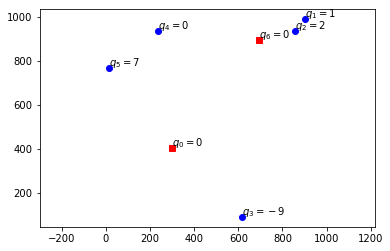

In [22]:
for point in coord[1:]:   
    plt.scatter(point[0], point[1], c='b')

for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (coord[i][0], coord[i][1]+10))

plt.plot(coord[0][0], coord[0][1], c='r', marker='s') #marker=(5, 1)
plt.plot(coord[end][0], coord[end][1], c='r', marker='s') 
plt.axis('equal')

### Formulazione e risoluzione del modello con CPLEX API
Le variabili decisionali per questa trattazione sono 3, le prime due sono state già utilizzate nella trattazione F2 e sono:
* $x_{ij}$ E' una variabile binaria che prende valore $1$ se l'arco è usato $0$ altrimenti per $(i,j) \in A$
* $f_{ij}$ E' una variabile continua che rappresenta il flusso sull'arco $(i,j)$ i.e. il carico del veicolo passante per l'arco $(i,j)$ per ogni $(i,j) \in A$
* $g_{ij}$ E' una variabile continua che rappresenta lo spazio residuo nel veicolo viaggiante lungo l'arco $(i,j)$ per $(i,j) \in A$

La funzione obiettivo e i vincoli sono stati impostati nella maniera sopra descritta in formule matematiche. Le funzioni di cplex utilizzate sono rispettivamente minimize per la funzione obiettivo e add_costraint/s per impostare i vincoli.

In [23]:
# Model
f4 = Model('Formulation-F4')

# Decision variables
x = f4.binary_var_dict(A_tilde, name='x')
f = f4.continuous_var_dict(A_tilde, name='f')
g = f4.continuous_var_dict(A_tilde, name='g')

In [24]:
#Function to minimize
f4.minimize(f4.sum(c[i, j]*x[i, j] for i in V for j in V))

#Constraints
f4.add_constraints(f4.sum(x[i, j] for i in V) == 1 for j in Vo) #17
f4.add_constraints(f4.sum(x[j, i] for i in V) == 1 for j in Vo) #18
f4.add_constraint(f4.sum(x[0, j] for j in V) <= m ) #19
f4.add_constraint(f4.sum(x[0, j] for j in Vo) == f4.sum(x[i, n-1] for i in Vo)) #20

for i in range(1, len(Vo) + 1):
    for S in itertools.permutations(Vo, i):
        f4.add_constraint(f4.sum(x[i, j] for j in S for i in S) <= len(S)-1) # 21
        
f4.add_constraints((f[i,j] + g[j,i]) == Q * x[i,j] for i in V for j in V)       #22
f4.add_constraints((f4.sum((f[j, i] - g[i,j]) for i in V) - f4.sum((f[i, j] - g[j,i]) for i in V)) == 2*q[j] for j in Vo) #23
f4.add_constraint(f4.sum(f[0,j] for j in Vo) >= max(0, -Qtot)) #24
f4.add_constraint(f4.sum(f[j,end] for j in Vo) >= max(0, Qtot)) #25
f4.add_constraint((f4.sum(g[j,0] for j in Vo) <= min(m*Q, m*Q + Qtot)))                   #26

f4.add_constraints((max(0,q[i],-q[j]) * x[i,j]) <= f[i,j] for i in V for j in V)                   #27_1
f4.add_constraints(f[i,j] <= (min(Q,Q + q[i],Q -q[j]) * x[i,j])  for i in V for j in V)                   #27_2

f4.add_constraints(((Q - min(Q, Q + q[i], Q - q[j])) * x[i,j]) <= g[j,i] for i in V for j in V)                 #28_1
f4.add_constraints((g[j,i] <= (Q - max(0, q[i], -q[j])) * x[i,j]) for i in V for j in V)                   #28_2


solutionF4 = f4.solve(log_output=True)
f4.solve(log_output=True)


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 4 times.
MIP Presolve eliminated 452 rows and 30 columns.
MIP Presolve modified 114 coefficients.
Aggregator did 38 substitutions.
Reduced MIP has 100 rows, 79 columns, and 435 nonzeros.
Reduced MIP has 31 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.82 ticks)
Found incumbent of value 7.0000000e+20 after 0.02 sec. (3.04 ticks)
Probing time = 0.00 sec. (0.12 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 100 rows, 79 columns, and 435 nonzeros.
Reduced MIP has 31 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.30 ticks)
Probing time = 0.00 sec. (0.12 ticks)
Clique table members: 24.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root 

docplex.mp.solution.SolveSolution(obj=4338.35,values={x_0_2:1,x_1_6:1,x_..

In [25]:
print(solutionF4)

solution for: Formulation-F4
objective: 0
x_0_2=1
x_1_6=1
x_2_3=1
x_3_5=1
x_4_1=1
x_5_4=1
f_0_2=7.000
f_1_6=8.000
f_2_3=9.000
f_4_1=7.000
f_5_4=7.000
g_1_4=3.000
g_2_0=3.000
g_3_2=1.000
g_4_5=3.000
g_5_3=10.000
g_6_1=2.000



In [26]:
print(solutionF4.solve_details)

status  = integer optimal solution
time    = 0.062 s.
problem = MILP
gap     = 0%



### Visualizzazione percorso ottimale con valore per la domanda

[(0, 2), (1, 6), (2, 3), (3, 5), (4, 1), (5, 4)]

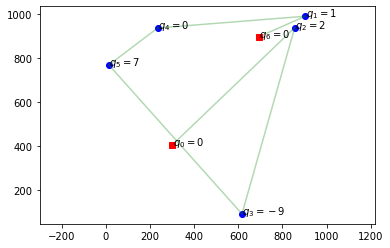

In [27]:

active_arcs = [a for a in A_tilde if x[a].solution_value > 0.9]

for point in coord[1:]:   
    plt.scatter(point[0], point[1], c='b')
    
for i in V:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (coord[i][0]+2, coord[i][1]))
    
for i, j in active_arcs:
    plt.plot([coord[i][0], coord[j][0]], [coord[i][1], coord[j][1]], c='g', alpha=0.3)
    
plt.plot(coord[0][0], coord[0][1], c='r', marker='s') # Starting depot
plt.plot(coord[n+1][0], coord[n+1][1], c='r', marker='s') # Ending depot
plt.axis('equal')

active_arcs

## Parte 2

### Valutazione

A partire dal dataset fornito insieme al paper, consultabile al link: http://www.or.unimore.it/site/home/online-resources/bike-sharing-rebalancing-problems/articolo1090035457.html verrà effettuata una valutazione del modello. <br/>
Essendo in generale l'operazione molto costosa in termini di ram e la macchina utilizzata non in grado di eseguire gli esempi del test set il numero di stazioni è stato ridotto in maniera da ottenere dei risultati. I risultati ottenuti nella formulazione F4 sono poi confrontati con i risultati delle altre formulazioni ottenute dai colleghi nel seguente esperimento: https://github.com/conema/bike-sharing-rebalancing/blob/master/bike-sharing-cplex.ipynb

Per leggere i dati a partire dai file di test.txt si può utilizzare la seguente funzione:

In [27]:
dataset  = open("InstancesBRP/3Bari10.txt", "r")

i = 0

while True:
    line = dataset.readline()

    if not line:
      break

    if(i == 0):
      nNodes = int(line)
      costs = {(i, j): 0 for i in range(nNodes) for j in range(nNodes)}
    elif(i == 1):
      qVertices = {i: int(q) for i, q in enumerate(line.split())}
    elif(i == 2):
      cVehicles = int(line)
    else:
      j = 0
      for el in line.split():
        costs[(i-3, j)] = float(el)
        j = j+1
      
    i = i+1

dataset.close()

Successivamente basterà effettuare gli assegnamenti ale variabili del problema:

In [26]:
#Initial values
n = nNodes                                    # amount of stations (Reggio-Emilia)
m = 2                                            # amount of vehicles
Q = cVehicles                                         # vehicles capacity
end = n + 1
Vo = [i for i in range(1, n+1)] # stations without starting and ending deposit   
V = [0] + Vo + [end] 
#A = [(i, j) for i in V for j in V]           # edges A_tilde
A_tilde = [(i, j) for i in V for j in V]  
q = qVertices           # demand along edges
q[n+1] = 0
Qtot = sum(q.values()) - q[0] - q[n+1]
c = costs

Ed eseguire la parte di notebook contrassegnata come <b>Formulazione e risoluzione del modello con CPLEX API<b/>


Ecco i risultati ottenuti dalla formulazione F4. 

|V  |F1           |F1|F1|F2            |F2|F2|F3         |F3|F3|F4               |F4|F4|
|---|-------------|------|------|--------------|------|------|-----------|------|-------|-----------------|-------|-------|
|   |Tempo        |Gap   |Gap r |Tempo         |Gap   |Gap r |Tempo      |Gap   |Gap r  |Tempo            |Gap    |Gap r  |
|5  |5s + 0s      |0%    |100%  |2s + 0s       |0%    |62.02%|2s + 0s    |0%    |100%   |1s + 0s          |0%     |100%   |
|8  |4s + 0s      |0%    |100%  |4s + 0s       |0%    |72.92%|5s + 0s    |0%    |100%   |4s +0s           |0%     |100%   |
|9  |21s + 2s     |0%    |100%  |20s + 2.56s   |0%    |72.55%|21s + 2s   |0%    |100%   |22s + 3s         |0%     |100%   |
|10 |3m12s + 26.2s|0%    |100%  |3m20s + 32.70s|0%    |74.07%|3m30s + 28s|0%    |100%   |out of memory 8gb|       |       |


Il test con 10 stazioni va in out of memory probabilmente dovuto alla limitata capacità in termini di ram del computer utilizzato. Questo è causato dal fatto che <b>i vincoli che sfruttano itertools</b> che portano alla generazione di un numero esponenziale di sottoinsiemi di nodi e questo necessità una grossa quantità di ram.
Per quanto riguarda i tempi, la maggior parte del tempo è impiegato per la creazione dei vincoli mentre il tempo necessario per la risoluzione è molto inferiore.

In conclusione ciò che si può dire è che questi test non bastano per dire che una formulazione sia migliore di un'altra. Per comprendere veramente le potenzialità di una formulazione rispetto ad un'altra e le differenze di performance relazionate ad una qualche variabile del problema sarebbe necessario effettuare altri test con vari valori di V.